In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask, z_score_normalize
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

dem_data = np.load("luse_and_dem/dem_0_5.npy")
dem_data = z_score_normalize(dem_data, np.mean(dem_data), np.var(dem_data))

# Convert to TensorFlow Constants
dem_tensor = tf.constant(dem_data, dtype=tf.float32)
dem_tensor = tf.expand_dims(dem_tensor, axis=-1)

def expand_static_data_dem(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor, 0), [batch_size, 1, 1, 1])

# Residual Block (Keeping Filters Constant)
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection within residual block

def create_edsr():
    input_img = Input(shape=(80, 145, 1))  # Low-resolution input

    dem_input = Lambda(expand_static_data_dem, output_shape=(160, 290, 1))(input_img)

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
    # x = LeakyReLU(alpha=0.2)(x)

    # Residual Blocks (Feature Extraction)
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Upsampling Layer moved to the end
    x = UpSampling2D(size=(2, 2))(x)  # Upscale to (160, 290)

    # Concatenate Upscaled Temperature with DEM
    x = Concatenate()([x, dem_input])

    # Fusion Layers
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [4]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 80, 145, 1)
(21478, 160, 290, 1)
(4602, 80, 145, 1)
(4602, 160, 290, 1)


In [19]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 80, 145, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 80, 145, 32)    │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 80, 145, 32)    │              0 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 80, 145, 32)    │              0 │ conv2d_23[0][0],       │
│                           │                        │                │ lambda_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 80, 145, 32)    │              0 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 80, 145, 32)    │              0 │ add_10[0][0],          │
│                           │                        │                │ lambda_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 80, 145, 32)    │              0 │ conv2d_28[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_13 (Lambda)        │ (None, 80, 145, 32)    │              0 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 80, 145, 32)    │              0 │ add_11[0][0],          │
│                           │                        │                │ lambda_13[0][0]        │
├──────────────────────

 Total params: 97,857 (382.25 KB)

 Trainable params: 97,857 (382.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - loss: 0.0323 - mae: 0.0323 - mse: 0.0057 - psnr: 28.8562 - ssim: 0.8417 - val_loss: 0.0092 - val_mae: 0.0092 - val_mse: 3.1610e-04 - val_psnr: 35.0024 - val_ssim: 0.9542 - learning_rate: 0.0010
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0084 - mae: 0.0084 - mse: 2.7278e-04 - psnr: 35.6714 - ssim: 0.9560 - val_loss: 0.0075 - val_mae: 0.0075 - val_mse: 1.9426e-04 - val_psnr: 37.1164 - val_ssim: 0.9591 - learning_rate: 0.0010
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0074 - mae: 0.0074 - mse: 1.8909e-04 - psnr: 37.2377 - ssim: 0.9595 - val_loss: 0.0068 - val_mae: 0.0068 - val_mse: 1.6548e-04 - val_psnr: 37.8128 - val_ssim: 0.9611 - learning_rate: 0.0010
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0070 - mae: 0.0070 - mse: 1.6598e-04 - psnr: 37.8015 - ssim: 0.9611 - val_loss: 0.0064 - val_mae: 0.0064 - val_mse: 1.5284e-04 - val_psnr: 38.1581 - val_ssim: 0.9622 

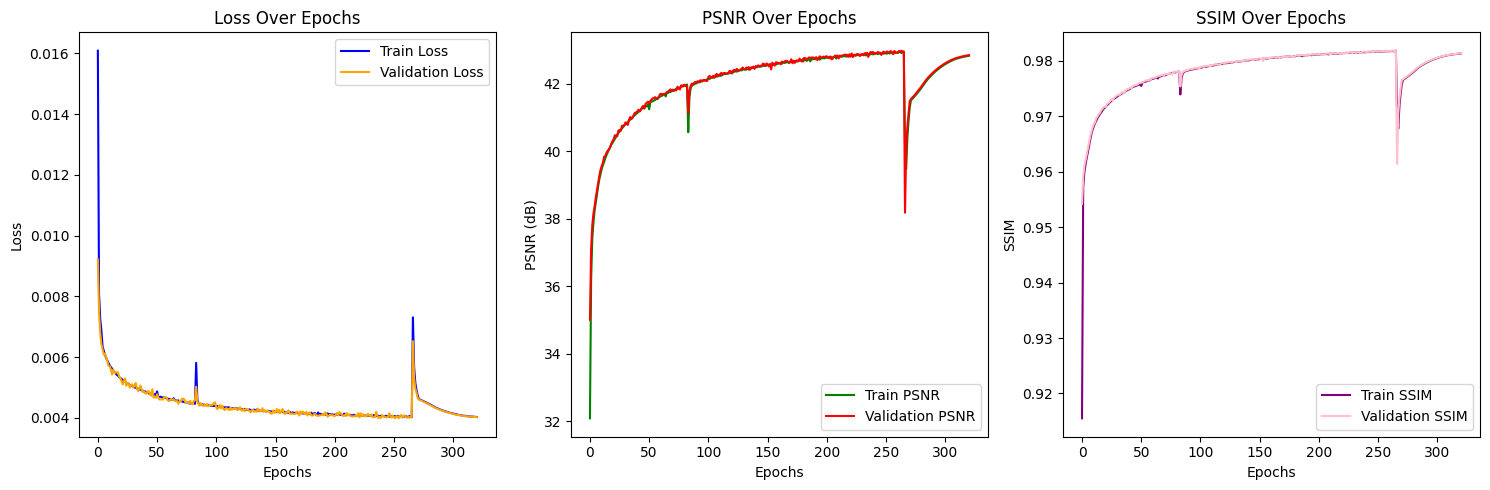

In [20]:
import time

start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 1000, 128, True, True, 150, 100)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


plot_history(history)
save_model(edsr_model, 'models/edsr_model_1to0_5_deg_200epochs_dem_method2.keras')

In [ ]:
edsr_model = tf.keras.models.load_model('models/edsr_model_1to0_5_deg_200epochs_dem_method2.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [21]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0041 - mae: 0.0041 - mse: 5.3787e-05 - psnr: 42.6972 - ssim: 0.9807
Test Loss: 0.00408463878557086
Test PSNR: 42.69446563720703
Test SSIM: 0.9807406663894653
Test MSE: 5.382147355703637e-05
Test MAE: 0.004084638319909573


In [22]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


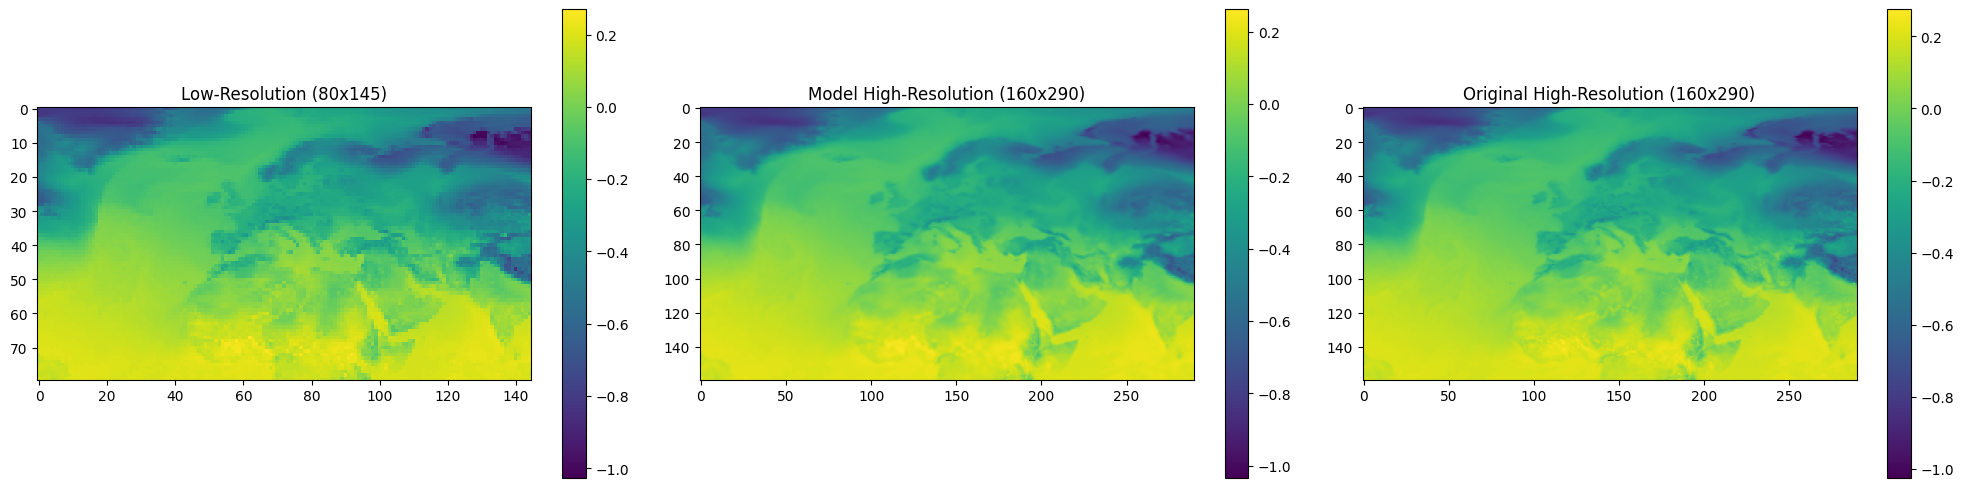

In [23]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

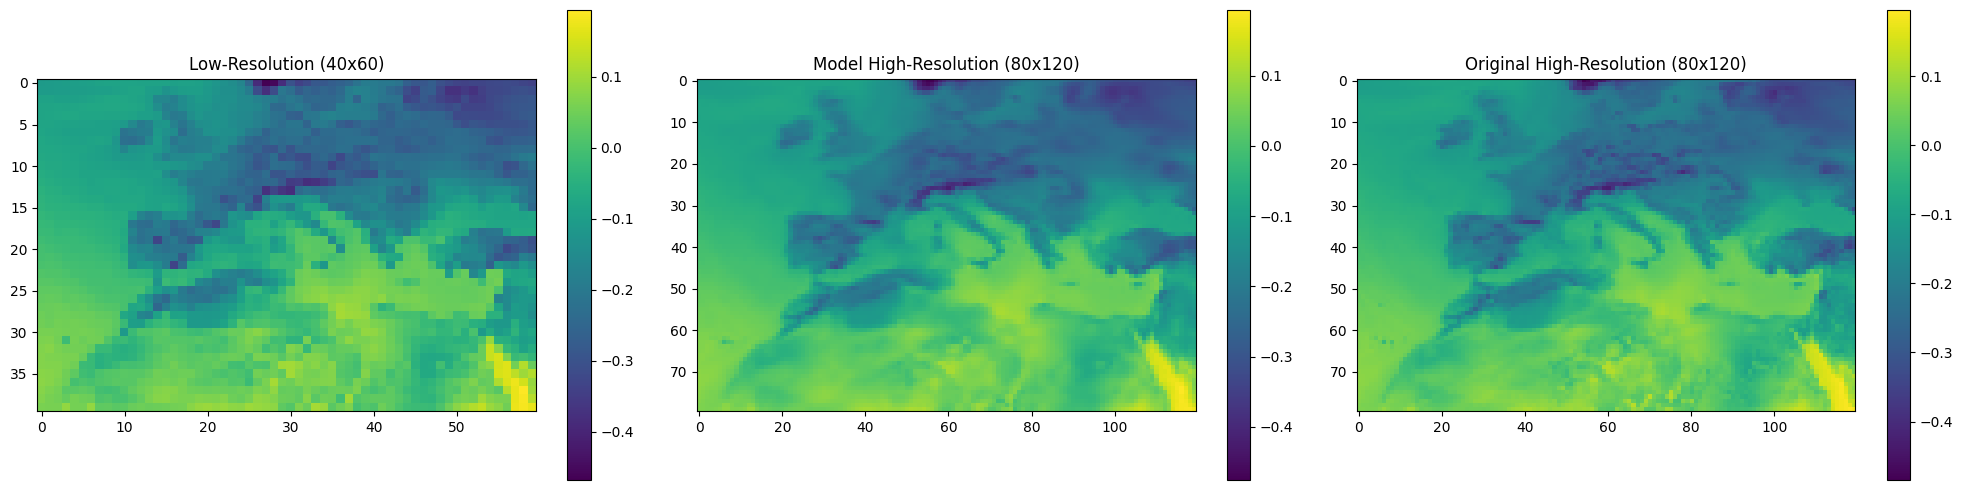

In [24]:
plot_to_compare(low_res_input[20:60, 40:100], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

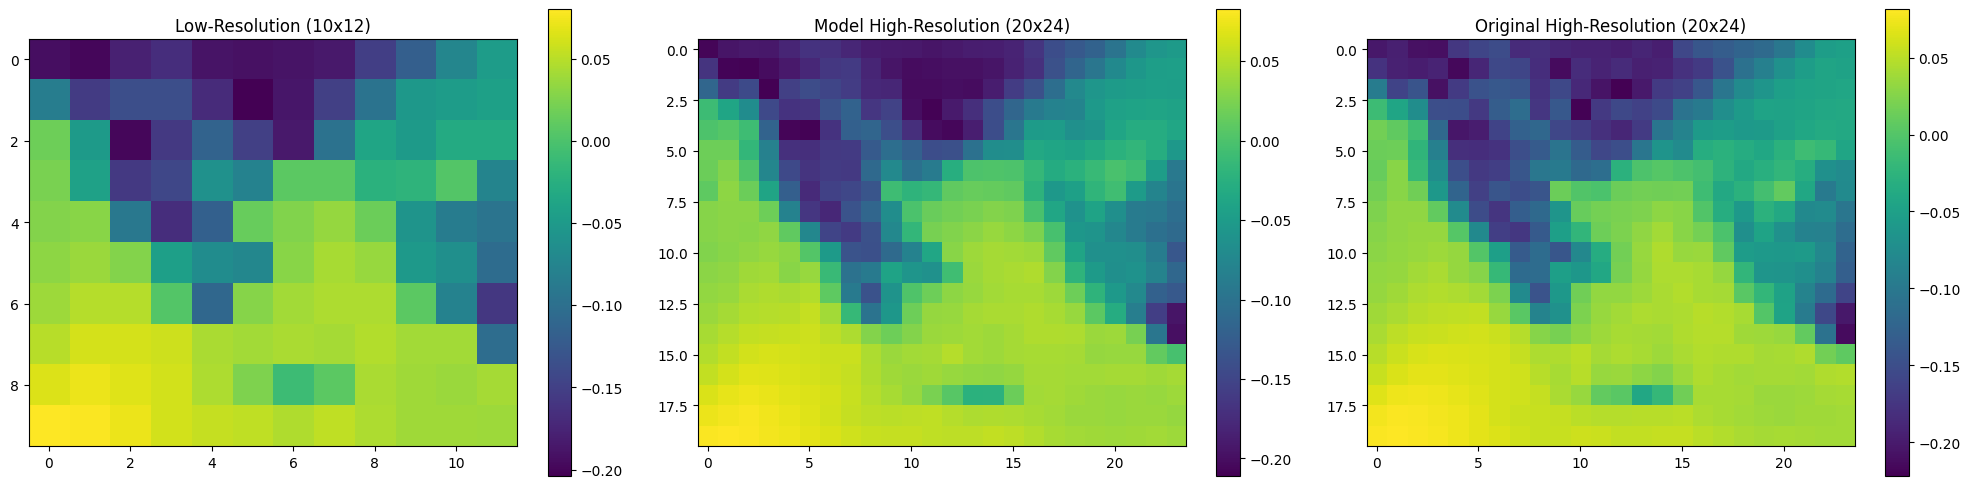

In [25]:
plot_to_compare(low_res_input[36:46, 78:90], np.squeeze(high_res_data)[72:92, 156:180],  np.squeeze(high_res_output)[72:92, 156:180], 'viridis')

In [26]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 5.382144e-05
Mean Per-Pixel MAE: 0.004084638
Mean Per-Pixel PSNR: 47.44624
Mean Per-Pixel SSIM: 0.99423856


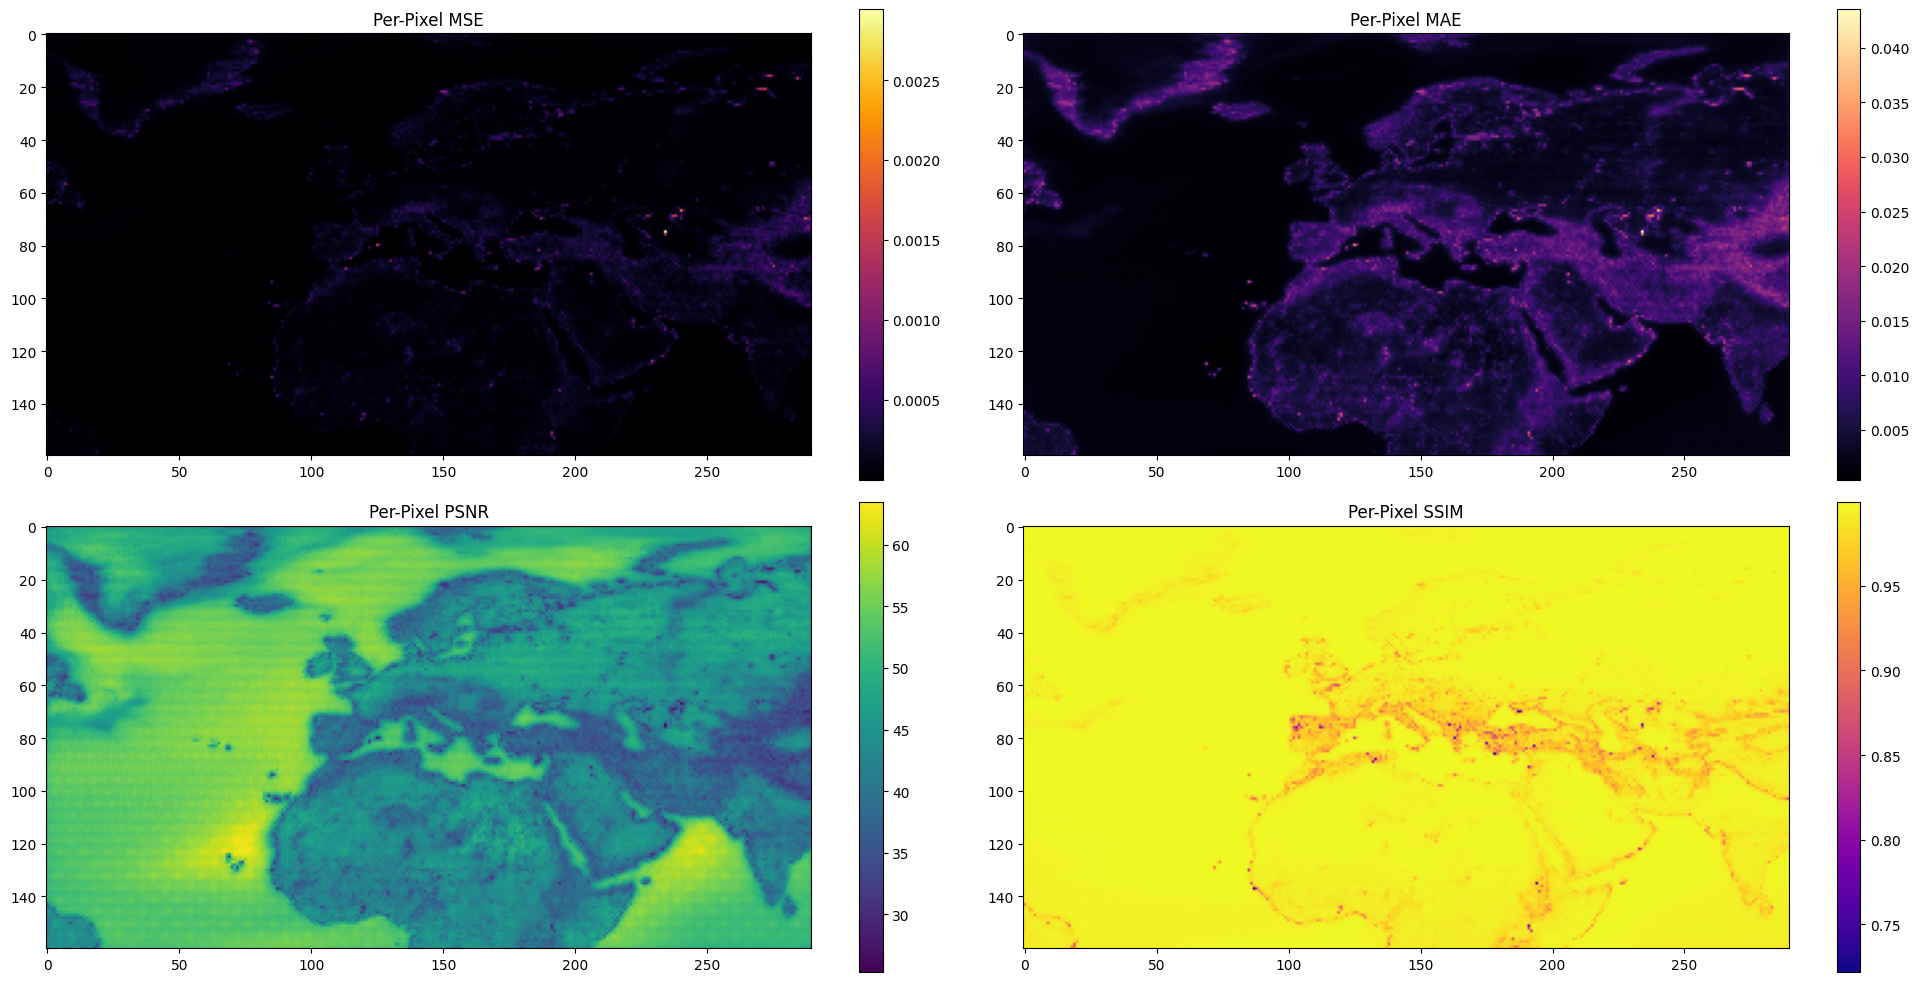

In [27]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.2624658
Max Degrees MAE: 2.798815
Min Degrees MAE: 0.029003097


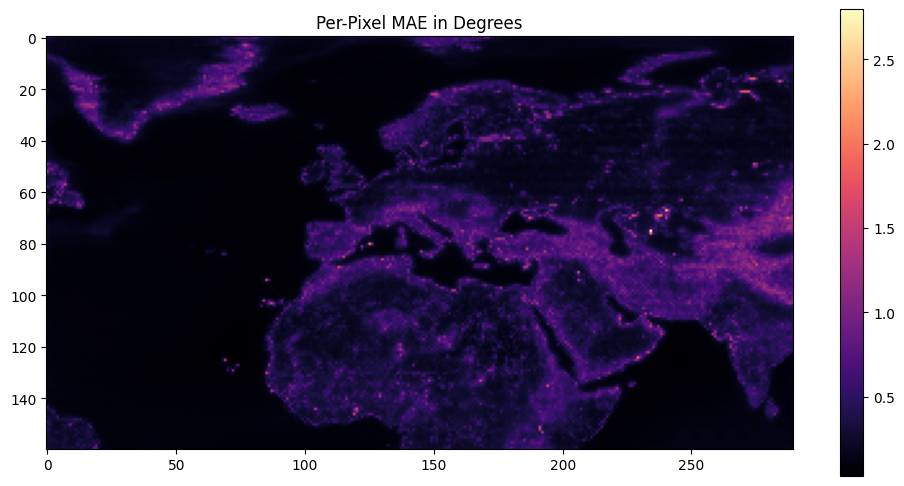

In [32]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [33]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.39513686
Mean Land-Pixels MAE: 0.006149339


In [30]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.5634554
Mean Costline-Pixels MAE: 0.008768804
